In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from imblearn.over_sampling import SMOTE


In [2]:
# Load the dataset
df = pd.read_csv("../dataset/train.csv")
df.head()

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.506494,2,0,0.083970,0,0,6,0.048387,-1,0,...,False,False,False,False,False,False,False,False,False,0
1,0.246753,3,0,0.072803,1,0,21,0.032258,175,1,...,False,False,False,False,False,False,True,False,False,0
2,0.181818,3,0,0.175531,0,0,23,0.000000,-1,0,...,False,False,False,False,False,True,False,False,False,0
3,0.441558,2,0,0.073757,0,1,22,0.048387,-1,0,...,False,False,True,False,False,False,False,False,False,0
4,0.428571,1,0,0.088183,0,0,13,0.016129,-1,0,...,False,False,False,False,False,False,False,False,False,0


In [3]:
# Drop the target variable from the features
X = df.drop(['y'], axis=1)
y = df['y']

In [4]:
# Check info and dtype of features and targets
X.info()
y.dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                31647 non-null  float64
 1   education          31647 non-null  int64  
 2   default            31647 non-null  int64  
 3   balance            31647 non-null  float64
 4   housing            31647 non-null  int64  
 5   loan               31647 non-null  int64  
 6   day_of_week        31647 non-null  int64  
 7   campaign           31647 non-null  float64
 8   pdays              31647 non-null  int64  
 9   previous           31647 non-null  int64  
 10  poutcome           31647 non-null  int64  
 11  job_admin.         31647 non-null  bool   
 12  job_blue-collar    31647 non-null  bool   
 13  job_entrepreneur   31647 non-null  bool   
 14  job_housemaid      31647 non-null  bool   
 15  job_management     31647 non-null  bool   
 16  job_retired        316

dtype('int64')

In [5]:
# Convert all boolean columns to float
X = df.astype({col: 'int' for col in df.select_dtypes('bool').columns}) ## talk about this in report

# Confirm all types are numeric now
print(X.dtypes)
X.head()


age                  float64
education              int64
default                int64
balance              float64
housing                int64
loan                   int64
day_of_week            int64
campaign             float64
pdays                  int64
previous               int64
poutcome               int64
job_admin.             int64
job_blue-collar        int64
job_entrepreneur       int64
job_housemaid          int64
job_management         int64
job_retired            int64
job_self-employed      int64
job_services           int64
job_student            int64
job_technician         int64
job_unemployed         int64
marital_divorced       int64
marital_married        int64
marital_single         int64
contact_cellular       int64
contact_telephone      int64
month_apr              int64
month_aug              int64
month_dec              int64
month_feb              int64
month_jan              int64
month_jul              int64
month_jun              int64
month_mar     

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.506494,2,0,0.083970,0,0,6,0.048387,-1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.246753,3,0,0.072803,1,0,21,0.032258,175,1,...,0,0,0,0,0,0,1,0,0,0
2,0.181818,3,0,0.175531,0,0,23,0.000000,-1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.441558,2,0,0.073757,0,1,22,0.048387,-1,0,...,0,0,1,0,0,0,0,0,0,0
4,0.428571,1,0,0.088183,0,0,13,0.016129,-1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Convert to numpy arrays
X = X.values
y = y.values
X.dtype, y.dtype

(dtype('float64'), dtype('int64'))

In [7]:
# Create a Neural Network class that inherits from nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 36)
        self.fc2 = nn.Linear(36, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
def train_model(model, X_train_tensor, y_train_tensor, 
                num_epochs=500, lr=0.001, print_every=50):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return losses


In [9]:
# Plot the training loss
def plot_training_loss(losses, num_epochs, title='Training Loss'):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def evaluate_model(model, X_test_tensor, y_test_tensor, class_names=None):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = torch.softmax(outputs, dim=1)
        predicted_probs = probs[:, 1].cpu().numpy() 
        _, predicted = torch.max(probs.data, 1)


    # Convert to numpy
    predicted_np = predicted.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # If class_names not provided, generate default labels
    if class_names is None:
        unique_classes = np.unique(y_test_np)
        class_names = [f'Class {i}' for i in unique_classes]

    # Metrics
    accuracy = accuracy_score(y_test_np, predicted_np)
    precision = precision_score(y_test_np, predicted_np, zero_division=0)
    recall = recall_score(y_test_np, predicted_np, zero_division=0)
    f1 = f1_score(y_test_np, predicted_np, zero_division=0)

    fpr, tpr, _ = roc_curve(y_test_np, predicted_probs)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"AUC:       {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, predicted_np)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
X_train = X.copy()
y_train = y.copy()

df_val = pd.read_csv("../dataset/validate.csv")
df_test = pd.read_csv("../dataset/test.csv")

for df in [df_val, df_test]:
    bool_cols = df.select_dtypes('bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

X_train_cols = df.columns.tolist()

X_val = df_val[X_train_cols].values
y_val = df_val['y'].values

X_test = df_test[X_train_cols].values
y_test = df_test['y'].values



In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [13]:
model = NeuralNetwork(input_size=X_train.shape[1])

In [14]:
losses = train_model(model, X_train_tensor, y_train_tensor, num_epochs=500, lr=0.001, print_every=50)

Epoch [50/500], Loss: 0.3422
Epoch [100/500], Loss: 0.2212
Epoch [150/500], Loss: 0.0659
Epoch [200/500], Loss: 0.0340
Epoch [250/500], Loss: 0.0188
Epoch [300/500], Loss: 0.0100
Epoch [350/500], Loss: 0.0042
Epoch [400/500], Loss: 0.0026
Epoch [450/500], Loss: 0.0014
Epoch [500/500], Loss: 0.0007


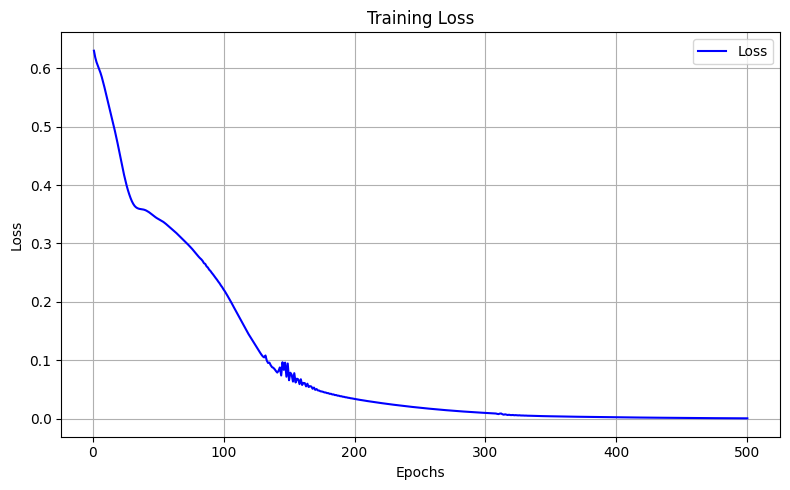

In [15]:
plot_training_loss(losses, num_epochs=500, title='Training Loss')

Accuracy:  1.0000
AUC:       1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


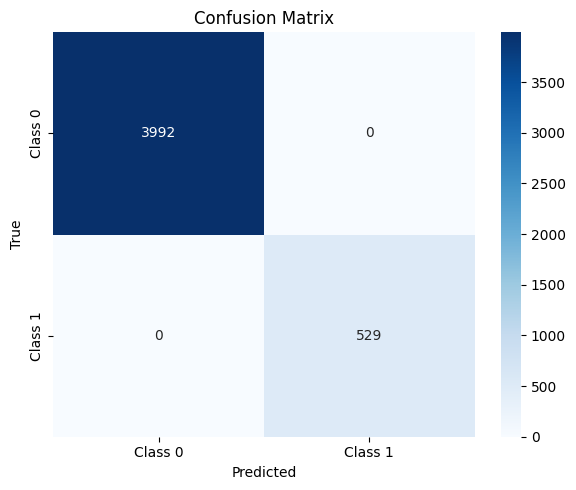

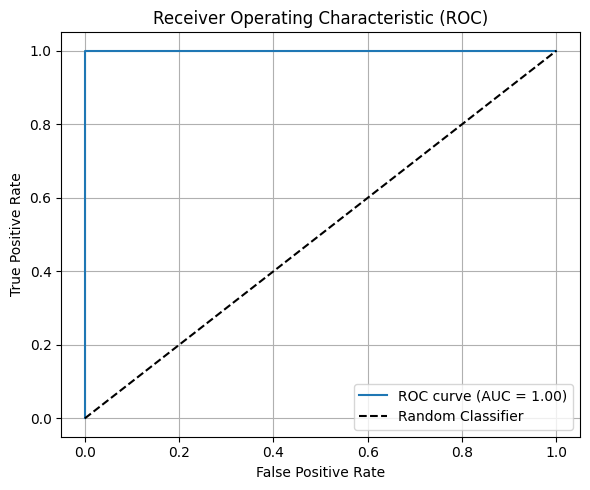

In [16]:
evaluate_model(model, X_val_tensor, y_val_tensor)

## Data Leakage



In [17]:
# x[['age', 'balance', 'campaign']] = scaler.fit_transform(x[['age', 'balance', 'campaign']])

# Introduces data leakage if done before splitting into train and test sets.
# That's because the MinMaxScaler learns the minimum and maximum values from the entire dataset,
# including the test set. This gives the model access to information it wouldn't have in a real-world scenario,
# resulting in overly optimistic performance. Always fit the scaler on the training set only.

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Load train data
df = pd.read_csv("../dataset/train.csv")
X = df.drop(['y'], axis=1)
y = df['y']

# Convert boolean columns to int in train
bool_cols = X.select_dtypes('bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Convert to numpy arrays
X = X.values
y = y.values

# Split train data
X_train = X.copy()
y_train = y.copy()

# Load validation and test data
df_val = pd.read_csv("../dataset/validate.csv")
df_test = pd.read_csv("../dataset/test.csv")

# Convert boolean columns to int for val and test
for df_ in [df_val, df_test]:
    bool_cols = df_.select_dtypes('bool').columns
    df_[bool_cols] = df_[bool_cols].astype(int)

# Use same columns as train for validation and test
X_train_cols = df.drop(['y'], axis=1).columns.tolist()

X_val = df_val[X_train_cols].values
y_val = df_val['y'].values

X_test = df_test[X_train_cols].values
y_test = df_test['y'].values

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [20]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
model = NeuralNetwork(input_size=X_train.shape[1])

In [ ]:
losses = train_model(model, X_train_tensor, y_train_tensor, num_epochs=1000, lr=0.001, print_every=50)

Epoch [50/1000], Loss: 0.3566
Epoch [100/1000], Loss: 0.3283
Epoch [150/1000], Loss: 0.3157
Epoch [200/1000], Loss: 0.3080
Epoch [250/1000], Loss: 0.3020
Epoch [300/1000], Loss: 0.2952
Epoch [350/1000], Loss: 0.2899
Epoch [400/1000], Loss: 0.2851
Epoch [450/1000], Loss: 0.2803
Epoch [500/1000], Loss: 0.2765
Epoch [550/1000], Loss: 0.2734
Epoch [600/1000], Loss: 0.2706
Epoch [650/1000], Loss: 0.2683
Epoch [700/1000], Loss: 0.2663
Epoch [750/1000], Loss: 0.2645
Epoch [800/1000], Loss: 0.2628
Epoch [850/1000], Loss: 0.2613
Epoch [900/1000], Loss: 0.2600
Epoch [950/1000], Loss: 0.2587
Epoch [1000/1000], Loss: 0.2574


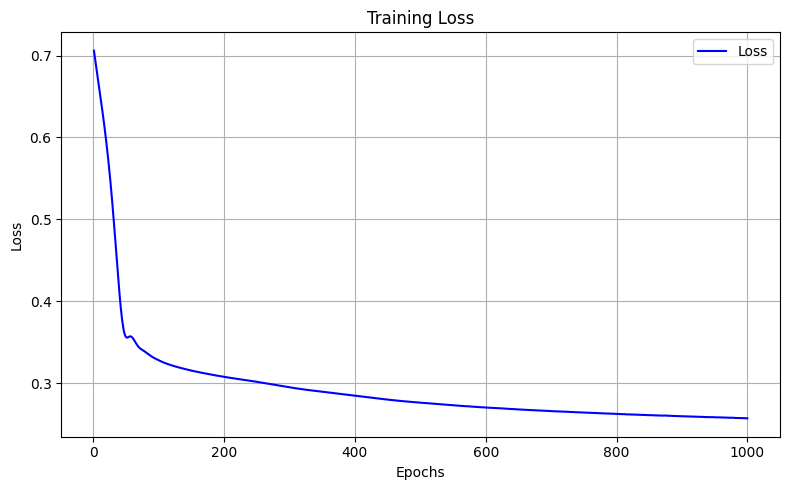

In [23]:
plot_training_loss(losses, num_epochs=1000, title='Training Loss')

Accuracy:  0.8965
AUC:       0.7878
Precision: 0.6215
Recall:    0.2949
F1 Score:  0.4000


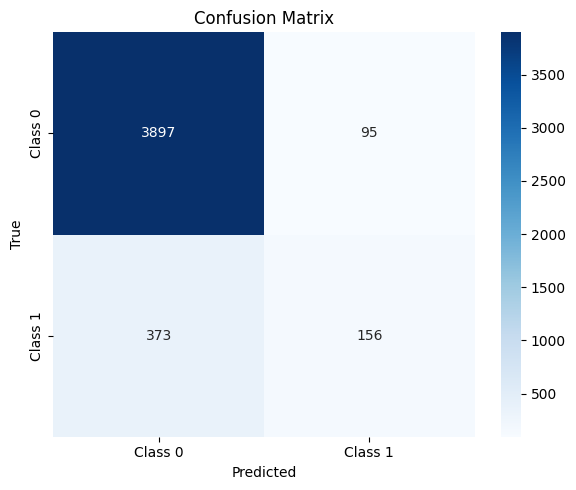

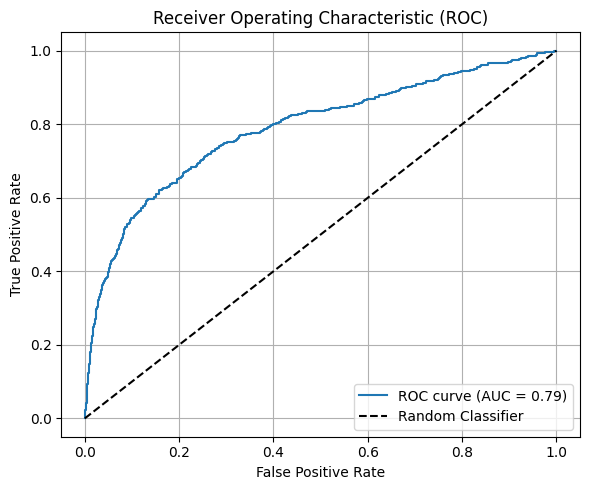

In [24]:
evaluate_model(model, X_val_tensor, y_val_tensor)

## Hyperparameter Optimisation

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# 1. Define the flexible neural network
class FlexibleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FlexibleNeuralNetwork, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, 2))  # Output layer for 2 classes
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 2. Define sklearn wrapper with L2 regularization support
class PyTorchNNClassifier(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"

    def __init__(self, input_size=20, hidden_sizes=[36, 32, 16], model_class=FlexibleNeuralNetwork,
                 lr=0.01, epochs=10, batch_size=32, optimizer_name='adam', weight_decay=0.0):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.model_class = model_class
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer_name = optimizer_name
        self.weight_decay = weight_decay

    def _get_optimizer(self, model):
        if self.optimizer_name == 'adam':
            return optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'rmsprop':
            return optim.RMSprop(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer_name}")

    def fit(self, X, y):
        X_tensor = torch.tensor(np.asarray(X), dtype=torch.float32)
        y_tensor = torch.tensor(np.asarray(y).ravel(), dtype=torch.long)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model_ = self.model_class(self.input_size, self.hidden_sizes)

        criterion = nn.CrossEntropyLoss()
        optimizer = self._get_optimizer(self.model_)

        self.model_.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                outputs = self.model_(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        self.model_.eval()
        X_tensor = torch.tensor(np.asarray(X), dtype=torch.float32)
        with torch.no_grad():
            logits = self.model_(X_tensor)
            preds = torch.argmax(logits, dim=1)
        return preds.numpy()
    
    def predict_proba(self, X):
        self.model_.eval()
        X_tensor = torch.tensor(np.asarray(X), dtype=torch.float32)
        with torch.no_grad():
            logits = self.model_(X_tensor)
            probs = torch.softmax(logits, dim=1)
        return probs.numpy()

    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)

# 4. Define parameter grid for GridSearchCV (including weight_decay)
param_grid = {
    'hidden_sizes': [
        [64, 32],
        [36, 32, 16]
    ],
    'lr': [0.01, 0.001],
    'epochs': [10, 20],
    'batch_size': [32, 64],
    'optimizer_name': ['adam', 'sgd'],
    'weight_decay': [1e-4, 1e-3]  # L2 regularization
}

# 5. Create classifier and run GridSearchCV
model = PyTorchNNClassifier(input_size=X_train.shape[1], model_class=FlexibleNeuralNetwork)
grid = GridSearchCV(model, param_grid, cv=3, scoring='f1', verbose=2)
grid.fit(X_train, y_train)

# 6. Evaluate best model
best_model = grid.best_estimator_
probs = best_model.predict_proba(X_test)
# roc_auc = roc_auc_score(y_test, probs[:, 1])

print("Best parameters:", grid.best_params_)
print("Test accuracy:", best_model.score(X_test, y_test))
# print("Test ROC AUC:", roc_auc)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   3.4s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   3.2s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   3.3s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.001; total time=   3.3s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.001; total time=   3.2s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=adam, weight_decay=0.001; total time=   3.2s
[CV] END batch_size=32, epochs=10, hidden_sizes=[64, 32], lr=0.01, optimizer_name=sgd, weight_decay=0.0001; total time=   2.4s
[CV] END batch_size=32, epochs=10, hidden_size

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)

def evaluate_model(y_true, predicted_labels, predicted_probs, class_names=None):
    # Convert to numpy arrays
    y_test_np = np.asarray(y_true)
    predicted_np = np.asarray(predicted_labels)
        
    # If class_names not provided, generate default labels
    if class_names is None:
        unique_classes = np.unique(y_test_np)
        class_names = [f'Class {i}' for i in unique_classes]

    # Metrics
    accuracy = accuracy_score(y_test_np, predicted_np)
    precision = precision_score(y_test_np, predicted_np, zero_division=0)
    recall = recall_score(y_test_np, predicted_np, zero_division=0)
    f1 = f1_score(y_test_np, predicted_np, zero_division=0)

    fpr, tpr, _ = roc_curve(y_test_np, predicted_probs[:, 1])
    
    # Save to CSV 
    results_df = pd.DataFrame({
        'y_test': y_test_np,
        'y_prob': predicted_probs[:, 1]
    })
    results_df.to_csv('nn_roc_values.csv', index=False)
    print("Saved predictions to 'nn_roc_values.csv'")

    roc_auc = auc(fpr, tpr)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"AUC:       {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, predicted_np)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Saved predictions to 'nn_roc_values.csv'
Accuracy:  0.8931
AUC:       0.7853
Precision: 0.6417
Recall:    0.1947
F1 Score:  0.2988


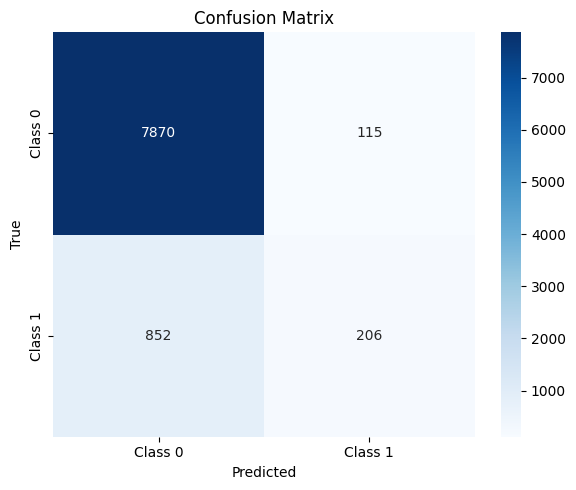

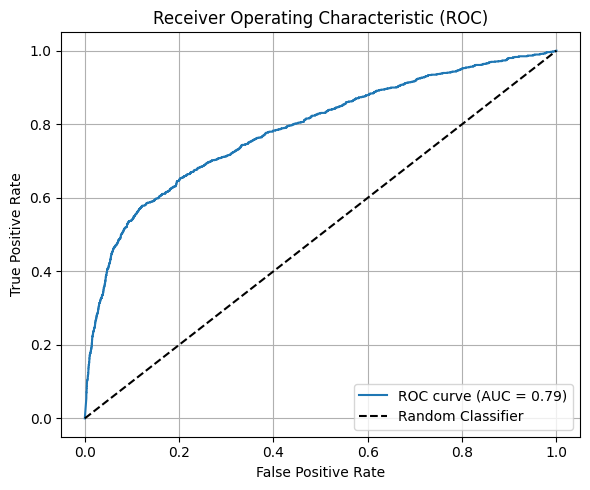

In [33]:
# After training best model
predicted_labels = best_model.predict(X_test)
predicted_probs = best_model.predict_proba(X_test)

evaluate_model(y_test, predicted_labels, predicted_probs)
